# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
### **Adam Tetelman**
***
In this project I used the tools that were taught througout the "identify lane lines on the road" lesson.

The project relies on the following packages:
- python3 (and standard libraries)
 - numpy (for array manipulation)
 - cv2 (for image processing - opencv2)  
 - matplotlib (for debugging/tuning and rendering images)
 - moviepy (for video rendering)
 - Jupyter/Ipython (for this notebook)


The tools taught included:
- Conversion between RGB and Grayscale
- Gaussian Blur
- Color Selection
- Polygon Region Selection
- Canny Edge Detection
- Hough Transform (Line Detection)

The resources used included:
- White line video (white.mp4)
- Yellow line video (yellow.mp4)
- Optional video (challenge.mp4)

The code (primarily the helper functions) was based off of provided sample code, along with discussions from the class Slack channel and Q&A sessions.

For this project I started off by creating a pipeline that would do edge detection on a set of images. I then extended the pipeline to draw lines for all edges. When the results from that were satisfactory I tested the pipeline out on provided videos of varying difficulty. The final step was to replace the series of edge lines with a single line for both the right and left lane.

Additionaly, as an optional last step I attempted several methods for improving the pipeline. I played around with a few image processing techniques such as contrast increase and color patch detection to improve edge detection. I also attempted alternative methods to improve lane detection, such as linear regression. Lastly I played around with several of the variables.

Finally, included with this Jupyter notebook is a full write up of the project, the proces, and some additional thoughts on the methods used herein.

## Expected Output

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">Sample edge and line detection output from first phase of project.</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">Goal output with lanes highlighted</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import os
import glob

import math

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Initial Environment Verification

Let's first verify things are working by checking our image/video directory and loading a few images.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


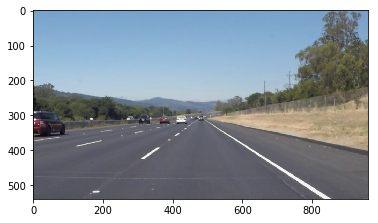

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
print(glob.glob("*mp4"))
os.listdir("test_images/")

['challenge.mp4', 'extra-raw.mp4', 'extra.mp4', 'P1_example.mp4', 'raw-lines-example.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4', 'white-raw.mp4', 'white.mp4', 'yellow-raw.mp4', 'yellow.mp4']


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Helper functions that wrap around external libraries. These were primarily pulled from the sample code and class examples.

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None or len(lines) == 0:
        return

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)           


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#### Additional Helper Functions

In [5]:
def color_select(image, low_threshold, high_threshold):
    '''Return an image containing only color values within the selected threshold
    Expects a grayscale image, returns a grayscale image
    '''
    return cv2.inRange(image, low_threshold, high_threshold)

def color_select_dynamic(image, constant, high_threshold):
    '''Wraps around color_select
    Calculates a low_threshold based on the average color of the image + a constant
    '''
    def get_color_threshold_dynamic(image, constant, max_val):
        '''Returns an image that only contains colors within the threshold'''
        threshold = np.mean(image)  + constant # TODO:
        if threshold > max_val:
            threshold = max_val
        return threshold
    
    low_threshold = get_color_threshold_dynamic(image,constant,high_threshold - 30)
    return color_select(image, low_threshold, high_threshold)

def increase_contrast(image, phi, theta):
    '''TODO: Unimplemented
    Adjusts the contrasts of an image
    '''
    img = ((255/phi) * (image / (255/theta)) ** 0.5)
    img2 = np.array(img, dtype=np.int32)
    return image


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Assumptions

Before progressing much forward we should identify some of the assumptions this pipeline is working off of. If any of these assumptions is broken the robustness of the pipeline will come into question and results will likely falter.

- The input will be a color image (or series of color imageS)
- The image will always have a visible left lane
- The image will always have a visible right lane
- The lanes will be a standard color (yellow or white)
- The camera angle that the image is taken from is consistent and taken from the front dash
- The camera view is slightly larger than the width of the car
- The left lane and the right lane will never be closer together than the width of a car
- - As would be the case in some merges, some construction, or with freshly/doubly painted lines
- The lanes may become unusually far apart
 - As in the case of some merges
- Both lanes are detectable within the bottom half of the image
- The left and right lanes have a similar slope 
- Lanes are never horizontal, very jagged, or overly sharp
 - Such as in the case of sharp turning, spinouts, lane shifting, or accidents

## Detecting Lane Lines
The method used to detect lane lines runs the results from Canny Edge detection through the Hough transform.

I then create a list to track the center and slope of each line segregated by whether or not the line belongs to the left or right lane. I determine whether the line is a left lane line or right lane lane based on the sign of the slope. 

I also throw away any lines with slopes that appear too extreme.

After creating those lists I am able to use some simple math and calculate the slope of each lane and the average center of each lane.

I take my predefined top/bottom values, my calculated center/slope values and am able to do some basic math to calculate the bottom and top (x,y) coordinates for each lane.  [(Y1-Y2) = m(X1-X2) where (X1,Y1) is the center, m is the slope, and (X2,Y2) is the bottom or top coordinate with known Y value].

The tricky part here was paying correct attention to signs.

#### Invalid Slope Parameters

In [6]:
# Define an invalid slope range 
invalid_slope_low_max = .05
invalid_slope_low_min = -.05
invalid_slope_high_max = 100 

#### make_lanes()

In [7]:
def make_lanes(img, rho, theta, threshold, min_line_len, max_line_gap, debug=False):
    '''Take an image and Hough transform variables and return an image with two distinct lanes'''
    # Predefine line top/bottom of lanes
    top = img.shape[0] /3 # 1/3 down the screen
    bottom = img.shape[0] # Bottom of the screen
    
    # Get a list of lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Create somes lists store store left/right line centers and slopes
    left_slope = []
    right_slope = []
    left_center = []
    right_center = []
    
    
    # Iterate through lines, calculating line slope/center
    # Throw out invalid lines, and sort left lane/right lane lines by slope sign
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            center = [(x2 + x1) / 2, (y2 + y1) / 2] 
            if slope > invalid_slope_high_max or slope < invalid_slope_low_max and slope > invalid_slope_low_min:
                continue
            if slope < 0: # Left slope
                left_slope.append(slope)
                left_center.append(center)
            elif slope >= 0: # right slope
                right_slope.append(slope)
                right_center.append(center)
                
    # Calculate the average right/left slopes
    left_slope = np.sum(left_slope) / len(left_slope)
    right_slope = np.sum(right_slope) / len(right_slope)
    
    # Calculate the average right/left center
    left_center = np.divide(np.sum(left_center, axis=0), len(left_center))
    right_center = np.divide(np.sum(right_center, axis=0), len(right_center))
    
    # Calculate the Left lane X coordinates 
    left_x_bottom = left_center[0] - ((left_center[1] - bottom) / (left_slope))
    left_x_top = left_center[0] - ((left_center[1] - top) / (left_slope))

    # Calculate the Right lane X coordinates
    right_x_bottom = right_center[0] - ((right_center[1] - bottom) / (right_slope))
    right_x_top = right_center[0] - ((right_center[1] - top) / (right_slope))
    
    # Create lane point lists for bookkeeping and convert potential floats to ints
    left_lane = [int(x) for x in [left_x_bottom, bottom, left_x_top, top]]
    right_lane = [int(x) for x in [right_x_bottom, bottom, right_x_top, top]]
    
    # Draw the lines on the image
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.line(image, (left_lane[0],left_lane[1]), (left_lane[2],left_lane[3]), [0, 255, 255], 5)
    cv2.line(image, (right_lane[0],right_lane[1]), (right_lane[2],right_lane[3]), [0, 55, 255], 5)
   
    return image

### Alternative Lane Detection With Linear Regression
The make_lanes_using_lineaer_regression function attempts to split the lanes up into their own region and then run a linear regression.

I am splitting the left and right lane using a simple polygon that covers most of the left/right half of the image. The image coming in should be the result of a canny edge detection.

I then run each region through a Hough transform. I take all the points from the Hough transform and fit a Linear Model to them. I then use the Linear Model to predict the X values for the top and bottom of the image and plot lines accordingly.

The results from this function, so far,  have been much less accurate and more jittery than using the method suggested in class. As such I am leaving it here as a record, but it is not used further in the project.

In [8]:
from sklearn.linear_model import LinearRegression


def  make_lanes_using_linear_regression(img, rho, theta, threshold, min_line_len, max_line_gap, debug=False):
    '''Takes an image that has been run through Canny edge detection and returns a blank image with left/right lanes drawnb
    Uses predfined polygons that define possible left/right lane boundries.
    Passes bounded lane regions to make_single_lane for left and right lane
    Overlays images and returns
    '''
    #Define polygons to select only left and right lane
    poly_y = image.shape[0]
    poly_x = image.shape[1]
    left_polygon_vertices = np.array([[(0, 0),
                                  (0, poly_y),
                                  (poly_x / 2 + poly_x / 10, poly_y), # A little bit right of center
                                  (poly_x / 2, 0)]], dtype=np.int32)  
    right_polygon_vertices = np.array([[(poly_x / 2, 0),
                                  (poly_x/ 2 - poly_x / 10, poly_y), # A little bit left of center
                                  (poly_x, poly_y),
                                  (poly_x, 0)]], dtype=np.int32)
    
    # Use polygon select to generate images for the left and right lane
    left_region = region_of_interest(img, left_polygon_vertices)
    right_region = region_of_interest(img, right_polygon_vertices)
    
    # Pass the lane images into make_single_lane function to draw a single lane line
    left_lane = make_single_lane(left_region, rho, theta, threshold, min_line_len, max_line_gap, left_side=True)
    right_lane = make_single_lane(right_region, rho, theta, threshold, min_line_len, max_line_gap, left_side=False)
    
    # DEBUG
    if debug:
        plt.imshow(left_lane); plt.show()
        plt.imshow(right_lane); plt.show()
        
    # Overlay left and right lane images
    return weighted_img(left_lane, right_lane)


def make_single_lane(img, rho, theta, threshold, min_line_len, max_line_gap, left_side):
    '''Take an image that should contain a single lane and return an image of that single lane drawn
    Uses cv2 HoughLinesP to determine where lines are in the image.
    Passes all found line points into sklearn LinearRegression model to create line of best fit
    Defines top/bottom of line to be top/bottom of image and predicts the X value for those locations
    Draws lines and returns image
    '''
    # Define the top/bottom of the image to be top/bottom of lanes
    top = 0
    bottom = img.shape[0]
    
    #Declare a linear Model
    lm = LinearRegression()
    
    # Get all of the lines detected
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Run through all of the lines and remove any that appear mostly horizontal
    valid_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            if slope > invalid_slope_high_max or slope < invalid_slope_low_max and slope > invalid_slope_low_min:
                continue # Close to horizontal slopes cannot be lanes
            valid_lines.append(line)

    # Fit the Linear Model so that we can predict X coordinates based on given Y Coordinates
    lm.fit(lines[:,:,1], lines[:,:,0])
    lm.fit(lines[:,:,3], lines[:,:,2])

    # Create a blank image, predict the left-most and right-most coordinates, and create a lane line
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if left_side:
        # For the left lane the bottom will be left-most and top will be right-most
        lane = [lm.predict(bottom), bottom, lm.predict(top), top]
    else:
        # For the right lane the bottom will be right-most and top will be left-most
        lane = [lm.predict(bottom), bottom, lm.predict(top), top] 
    cv2.line(image, (lane[0],lane[1]), (lane[2],lane[3]), [0, 255, 255], 5)
    
    return image

## Defining the Image Processing Pipeline

For the actual Image processing pipeline I seperated the tuning parameters into a block of code and the main pipeline into another. There are also some helper functions for rendering images.

The main pipeline is in highlight_lanes() and does the following:

original_image -> higher_contrast -> guassian_blur -> color_selection -> edge_detection -> region_selection -> lane_detection

The pipeline allows for some debug image printing as well out outputting lines instead of lanes for parameter tuning and debugging.

I played around a small amount with the order of operations, as well as structuring the code in a few different ways and chaining the function calls rather than saving them to variables. I was unable see see any significant performance improvements from the current state.

contrast#### Lane and Line Detection Parameters

In [9]:
# Contrast params
contrast_phi = .5
contrast_theta = 20

# Gaussian blur kernel
blur_kernel_size = 3

# Canny Edge detection
canny_ratio = 3
canny_low_threshold = 70
canny_high_threshold = canny_low_threshold * canny_ratio

# Color selection
color_low = 200
color_high = 255
    
# Hough Line detection
hough_rho = 2 # max resolution is 1
hough_theta = np.pi/180 # max resolution is 1
hough_threshold = 60
hough_min_line_len = 10
hough_max_line_gap = 100

# Region selection
poly_y = image.shape[0]
poly_x = image.shape[1]
polygon_vertices = np.array([[(poly_x / 2 - poly_x / 15, poly_y / 3),
                              (poly_x/2 - poly_x / 30, poly_y - poly_y / 12),
                              (poly_x/2 + poly_x / 30, poly_y - poly_y / 12),
                              (poly_x / 2 + poly_x / 15, poly_y / 3),
                              (poly_x, poly_y),
                              (0, poly_y)]], dtype=np.int32)

In [10]:
def highlight_lanes(image, output_edges=False, debug=False, full_debug=True):
    '''Take a lane, run it through a pipeline and return an identical image with lanes highlighted
    Includes output_edges option which will highlited detected edges instead of drawning lanes.
    Includes several predefined model variables.
    '''    
    # In case we can't detect a line at some point in the pipeline we wrap this in a try/except
    # In the case of no lane, we return an unmodified image
    try:
        contrast = increase_contrast(image, contrast_phi, contrast_theta)
        gray = grayscale(contrast)
        blur = gaussian_blur(gray, blur_kernel_size)
        color = color_select(blur, color_low, color_high)
        edge = canny(color, canny_low_threshold, canny_high_threshold)
        region = region_of_interest(edge, polygon_vertices)
        lanes = make_lanes(region, hough_rho, hough_theta, hough_threshold,hough_min_line_len, hough_max_line_gap)
        final_lanes = weighted_img(lanes, image)
    except (TypeError, IndexError) as e:
        return image # If no lanes are detected return the original image
    
    # DEBUG, used to print images during the tuning phase
    if debug:
        select_region = region_of_interest(image, polygon_vertices) # Print this for debug only
        lines_detected = hough_lines(region, hough_rho, hough_theta, hough_threshold,hough_min_line_len, hough_max_line_gap) 
        images = [gray, blur, color, edge, select_region, region,
                  lines_detected, lanes, final_lanes]
        
        # Create a figure containing all images
        i = 1
        figure = plt.figure()
        for image in images:
            figure.add_subplot(len(images) / 2 + 1 ,2,  i)
            plt.imshow(image)
            i += 1
        plt.show()
        
        #Show all individual images
        if full_debug:
            step = 0
            for image in images:
                plt.imshow(image); plt.show()
                mpimg.imsave("%sprocess-step-%d.jpg"%(results_dir, step),image) 
                step += 1
    
    # Used to compare line detection to lane detection, not used in the final image
    if output_edges:
        lines_detected = hough_lines(region, hough_rho, hough_theta, hough_threshold,hough_min_line_len, hough_max_line_gap) 
        final_lines = weighted_img(lines_detected, image)
        return final_lines
    
    return final_lanes

#### Helper functions to process single images

In [11]:
def write_lane_image(image, name, output_edges=False, debug=False):
    '''Process a single image and write results to disk'''
    mpimg.imsave(name, highlight_lanes(image, output_edges, debug))

    
def process_lane_images(test_dir, results_dir, output_edges=False, debug=False):
    '''Process all images in a test directory and output them to a results_directory'''
    image_list = os.listdir(test_dir)
    for image_name in image_list:
        input_f = os.path.join(test_dir, image_name)
        output_f = os.path.join(results_dir, image_name)
        write_lane_image(mpimg.imread(input_f), output_f, output_edges, debug)

## Testing the Pipeline

### Test using images

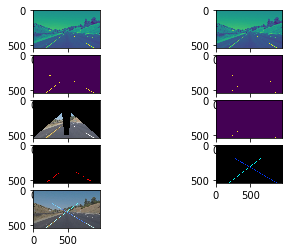

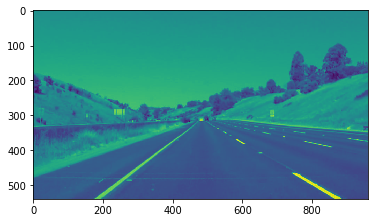

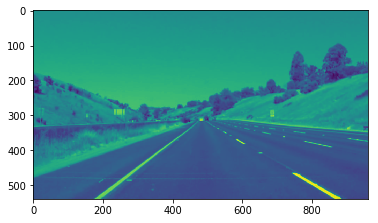

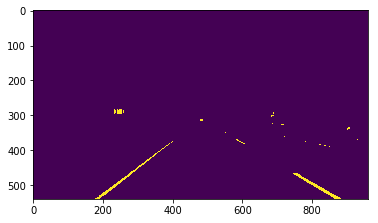

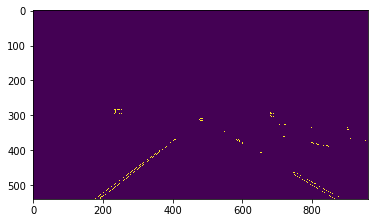

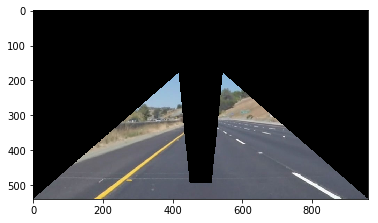

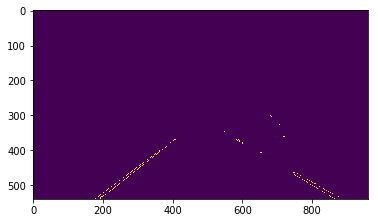

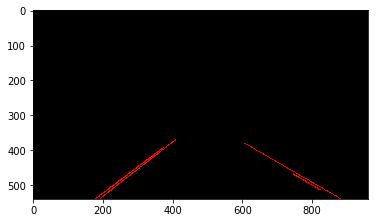

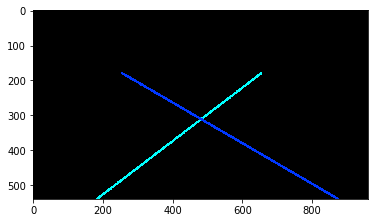

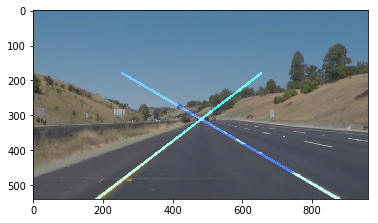

['process-step-0.jpg',
 'process-step-1.jpg',
 'process-step-2.jpg',
 'process-step-3.jpg',
 'process-step-4.jpg',
 'process-step-5.jpg',
 'process-step-6.jpg',
 'process-step-7.jpg',
 'process-step-8.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [12]:
results_dir = "results/"
test_dir = "test_images/"
os.makedirs(results_dir, exist_ok=True)

# We are going to do one debug image to capture the pipeline process
debug_img = mpimg.imread(os.path.join(test_dir, "whiteCarLaneSwitch.jpg"))
write_lane_image(debug_img,"debug", debug=True)

process_lane_images(test_dir, results_dir, output_edges=False, debug=False) # Let's process the rest without debug

os.listdir(results_dir)

### Test using videos

I then wrote some minor image_processing code that will call the highlight_lanes function for each clip in a video stream.

There were three test videos or progressing complexity:
- `solidWhiteRight.mp4`
- `solidYellowLeft.mp4`
- `challenge.mp4`

For completeness I ran all videos through both lane detection and line detection. The output can be seen side by side in the same cells.

#### Video processing helper code

In [13]:
def process_image(image):
    return highlight_lanes(image, output_edges=False)


def process_image_raw(image):
    return highlight_lanes(image, output_edges=True)

First we process the solidwhite video. This took around 30 second for each video on my computer.

In [14]:
white_output = os.path.join(results_dir,'white.mp4')
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

white_output_raw = os.path.join(results_dir,'white-raw.mp4')
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip_raw = clip1.fl_image(process_image_raw)
%time white_clip_raw.write_videofile(white_output_raw, audio=False)

[MoviePy] >>>> Building video results/white.mp4
[MoviePy] Writing video results/white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:28<00:00,  7.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/white.mp4 

Wall time: 30.1 s
[MoviePy] >>>> Building video results/white-raw.mp4
[MoviePy] Writing video results/white-raw.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:28<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/white-raw.mp4 

Wall time: 30.4 s


The videos are saved locally, but it is also displayed in-line below.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
<video width="960" height="540" controls>
  <source src="{1}">
</video>
""".format(white_output, white_output_raw))

Next the same process with the yellow line video.

In [16]:
yellow_output = os.path.join(results_dir,'yellow.mp4')
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

yellow_output_raw = os.path.join(results_dir,'yellow-raw.mp4')
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip_raw = clip2.fl_image(process_image_raw)
%time yellow_clip_raw.write_videofile(yellow_output_raw, audio=False)

[MoviePy] >>>> Building video results/yellow.mp4
[MoviePy] Writing video results/yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [01:24<00:00,  8.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/yellow.mp4 

Wall time: 1min 26s
[MoviePy] >>>> Building video results/yellow-raw.mp4
[MoviePy] Writing video results/yellow-raw.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [01:34<00:00,  7.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/yellow-raw.mp4 

Wall time: 1min 36s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

<video width="960" height="540" controls>
  <source src="{1}">
</video>
""".format(yellow_output, yellow_output_raw))

# Optional Challenge

The below video contains a video with a more difficult scenario. It was optional for the assignment. 
- The car can be seen on the bottom part of the screen
- There is a section of bridge where the road is similar brightness to the lines
- There is more tricky ligthing in the horizon

In [18]:
challenge_output = os.path.join(results_dir,'extra.mp4')
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

challenge_output_raw = os.path.join(results_dir,'extra-raw.mp4')
clip2 = VideoFileClip('challenge.mp4')
challenge_clip_raw = clip2.fl_image(process_image_raw)
%time challenge_clip_raw.write_videofile(challenge_output_raw, audio=False)

[MoviePy] >>>> Building video results/extra.mp4
[MoviePy] Writing video results/extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:52<00:00,  4.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/extra.mp4 

Wall time: 56 s
[MoviePy] >>>> Building video results/extra-raw.mp4
[MoviePy] Writing video results/extra-raw.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:52<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/extra-raw.mp4 

Wall time: 56.1 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
<video width="960" height="540" controls>
  <source src="{1}">
</video>
""".format(challenge_output, challenge_output_raw))